# Handwriten digit generation

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import time
from tensorflow import keras
from tensorflow.keras import layers
import os

# Downloading data

In [ ]:
(train_images,train_labels),(test_images,test_labels) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


#Creating dataset with 9 as the only image

In [ ]:
digit9_images = []
for i in range(len(train_images)):
    if train_labels[i] == 9:
        digit9_images.append(train_images[i])
train_images = np.array(digit9_images)

In [ ]:
train_images.shape

(5949, 28, 28)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


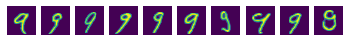

In [ ]:
n = 10
f = plt.figure()
for i in range(n):
    f.add_subplot(1, n, i + 1)
    plt.subplot(1, n, i+1 ).axis("off")
    plt.imshow(train_images[i])
plt.show()

# Preparing dataset

In [ ]:
train_images = train_images.reshape (
    train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 
train_dataset = tf.data.Dataset.from_tensor_slices(
    train_images).shuffle(train_images.shape[0]).batch(32)

##Creating generator model

In [ ]:
gen_model = tf.keras.Sequential()

# Feed network with a 7x7 random image
gen_model.add(tf.keras.layers.Dense(7*7*256, 
                                    use_bias=False, 
                                    input_shape=(100,)))
# Add batch normalization for stability 
gen_model.add(tf.keras.layers.BatchNormalization())
gen_model.add(tf.keras.layers.LeakyReLU())

# reshape the output
gen_model.add(tf.keras.layers.Reshape((7, 7, 256)))

# Apply (5x5) filter and shift of (1,1). 
# The image output is still 7x7.  
gen_model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), 
                                              strides=(1, 1), 
                                              padding='same', 
                                              use_bias=False))
gen_model.add(tf.keras.layers.BatchNormalization())
gen_model.add(tf.keras.layers.LeakyReLU())

# apply stride of (2,2). The output image is now 14x14.
gen_model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), 
                                              strides=(2, 2), 
                                              padding='same', 
                                              use_bias=False))
gen_model.add(tf.keras.layers.BatchNormalization())
gen_model.add(tf.keras.layers.LeakyReLU())

# another shift upscales the image to 28x28, whihch is our final size.
gen_model.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), 
                                              strides=(2, 2), 
                                              padding='same', 
                                              use_bias=False, 
                                              activation='tanh'))

In [ ]:
gen_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

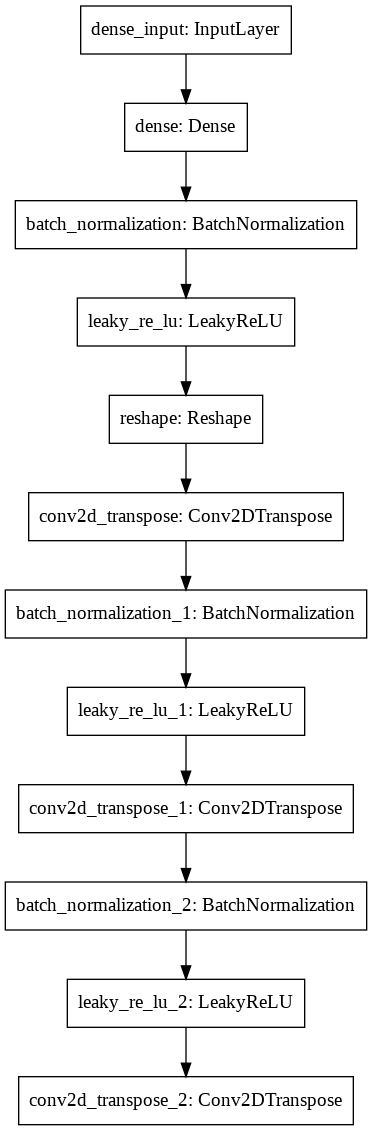

In [ ]:
tf.keras.utils.plot_model(gen_model)

# Testing image generator with random input vector

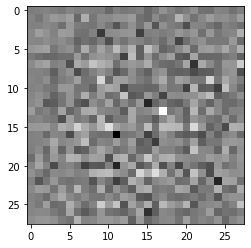

In [ ]:
noise = tf.random.normal([1, 100])#giving random input vector
generated_image = gen_model(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [ ]:
generated_image.shape

TensorShape([1, 28, 28, 1])

# Defining Discriminator model

In [ ]:
discri_model = tf.keras.Sequential()

discri_model.add(tf.keras.layers.Conv2D(64, (5, 5), 
                                        strides=(2, 2), 
                                        padding='same',
                                        input_shape=[28, 28, 1]))
discri_model.add(tf.keras.layers.LeakyReLU())
discri_model.add(tf.keras.layers.Dropout(0.3))
      
discri_model.add(tf.keras.layers.Conv2D(128, (5, 5), 
                                        strides=(2, 2), 
                                        padding='same'))
discri_model.add(tf.keras.layers.LeakyReLU())
discri_model.add(tf.keras.layers.Dropout(0.3))

discri_model.add(tf.keras.layers.Flatten())
discri_model.add(tf.keras.layers.Dense(1))

In [ ]:
discri_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

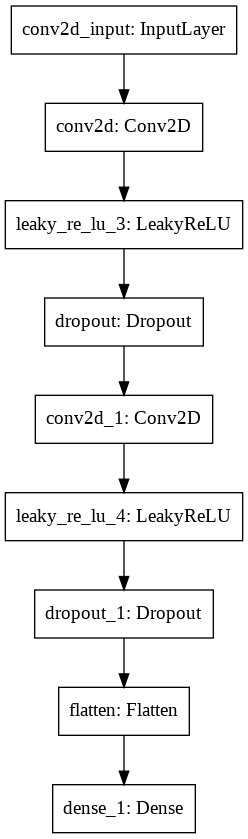

In [ ]:
tf.keras.utils.plot_model(discri_model)

# Testing Discriminator

In [ ]:
decision = discri_model(generated_image)
print (decision)

tf.Tensor([[0.00166516]], shape=(1, 1), dtype=float32)


# Loss functions

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True) #creating loss function

In [ ]:
def generator_loss(generated_output):
    return cross_entropy(tf.ones_like(generated_output),generated_output)

In [ ]:
def discriminator_loss(real_output, generated_output):
    # compute loss considering the image is real [1,1,...,1]
    real_loss = cross_entropy(tf.ones_like(real_output),real_output)

    # compute loss considering the image is fake[0,0,...,0]
    generated_loss = cross_entropy(tf.zeros_like(generated_output),
                                   generated_output)

    # compute total loss
    total_loss = real_loss + generated_loss

    return total_loss

# Optimizers

In [ ]:
gen_optimizer = tf.optimizers.Adam(1e-4)
discri_optimizer = tf.optimizers.Adam(1e-4)

### Setting up a few variables

In [ ]:
epoch_number = 0
EPOCHS = 100
noise_dim = 100
seed = tf.random.normal([1, noise_dim])

In [ ]:
checkpoint_dir = '/content/drive/My Drive/GAN1/Checkpoint'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=gen_optimizer,
                                 discriminator_optimizer=discri_optimizer, 
                                 generator= gen_model,
                                 discriminator = discri_model)

## Mounting drive for storing images and checkpoints

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd '/content/drive/My Drive/GAN1'

/content/drive/My Drive/GAN1


# Gradient tuning function

In [ ]:
def gradient_tuning(images):
    # create a noise vector.
    noise = tf.random.normal([16, noise_dim])

    # Use gradient tapes for automatic differentiation 
    with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape: 

      # ask genertor to generate random images
      generated_images = gen_model(noise, training=True)

      # ask discriminator to evalute the real images and generate its output
      real_output = discri_model(images, training=True)

      # ask discriminator to do the evlaution on generated (fake) images
      fake_output = discri_model(generated_images, training=True)

      # calculate generator loss on fake data
      gen_loss = generator_loss(fake_output)

      # calculate discriminator loss as defined earlier
      disc_loss = discriminator_loss(real_output, fake_output)

    # calculate gradients for generator
    gen_gradients = generator_tape.gradient(gen_loss, 
                                               gen_model.trainable_variables)

    # calculate gradients for discriminator
    discri_gradients = discriminator_tape.gradient(disc_loss, 
                                        discri_model.trainable_variables)

    # use optimizer to process and apply gradients to variables
    gen_optimizer.apply_gradients(zip(gen_gradients, 
                                            gen_model.trainable_variables))
    
    # same as above to discriminator
    discri_optimizer.apply_gradients(
        zip(discri_gradients, 
            discri_model.trainable_variables))

# Function for generating images at every epoch

In [ ]:
    def generate_and_save_images(model, epoch, test_input):
        # use a global count for tracking epochs in case of disconnection
        global epoch_number
        epoch_number = epoch_number + 1

        # set training to false to ensure inference mode
        predictions = model(test_input, training=False)

        # display and save image
        fig = plt.figure(figsize=(4,4))
        for i in range(predictions.shape[0]):
            plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
            plt.axis('off')
        plt.savefig('image_at_epoch_{:01d}.png'.format(epoch_number))
        plt.show()

# Setting up a training loop

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      gradient_tuning(image_batch)
    
    # Produce images as we go
    generate_and_save_images(gen_model,
                             epoch + 1,
                             seed)
    
    # save checkpoint data
    checkpoint.save(file_prefix = checkpoint_prefix)
    print ('Time for epoch {} is {} sec'.format(epoch + 1, 
                                                time.time()-start))

# Model training

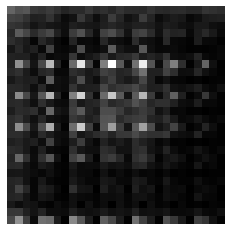

Time for epoch 1 is 7.095414161682129 sec


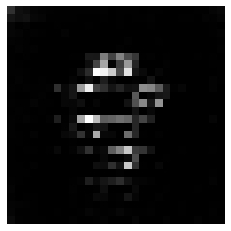

Time for epoch 2 is 6.984834909439087 sec


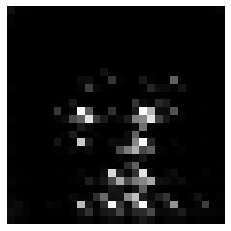

Time for epoch 3 is 7.086858510971069 sec


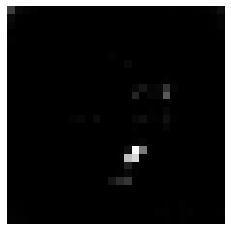

Time for epoch 4 is 7.1345555782318115 sec


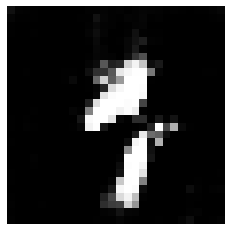

Time for epoch 5 is 7.1410017013549805 sec


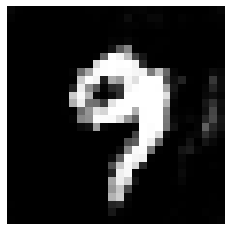

Time for epoch 6 is 7.051345348358154 sec


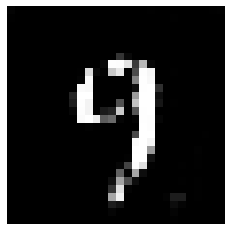

Time for epoch 7 is 7.242609977722168 sec


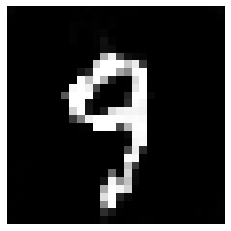

Time for epoch 8 is 7.063942909240723 sec


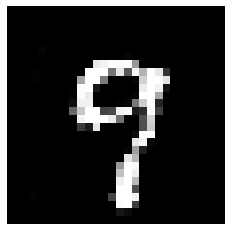

Time for epoch 9 is 7.136502504348755 sec


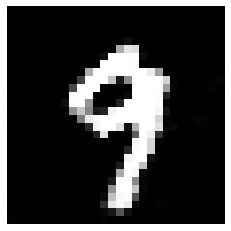

Time for epoch 10 is 7.325074911117554 sec


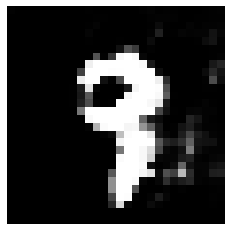

Time for epoch 11 is 7.351783990859985 sec


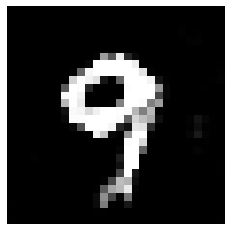

Time for epoch 12 is 7.357706785202026 sec


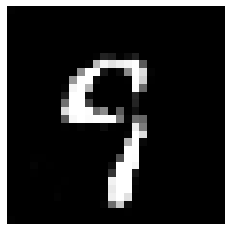

Time for epoch 13 is 7.704578161239624 sec


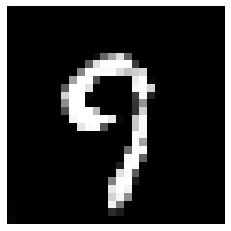

Time for epoch 14 is 7.281912326812744 sec


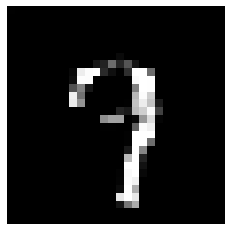

Time for epoch 15 is 7.267755508422852 sec


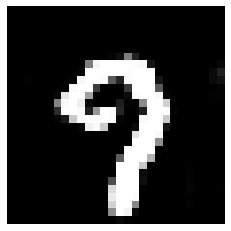

Time for epoch 16 is 7.483854293823242 sec


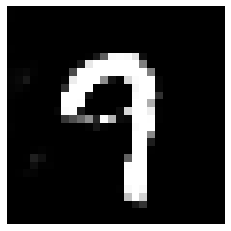

Time for epoch 17 is 7.1492760181427 sec


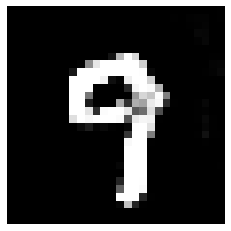

Time for epoch 18 is 7.349060297012329 sec


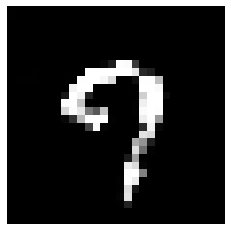

Time for epoch 19 is 7.725026369094849 sec


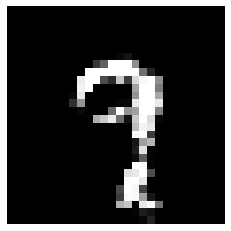

Time for epoch 20 is 7.070832252502441 sec


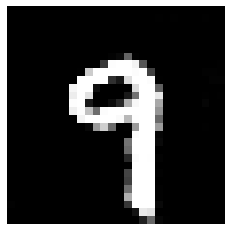

Time for epoch 21 is 6.372117280960083 sec


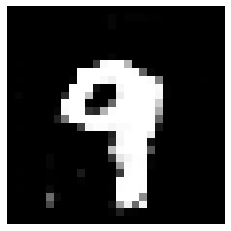

Time for epoch 22 is 6.676779270172119 sec


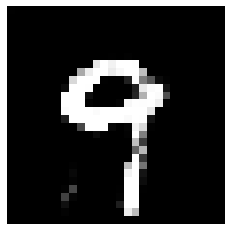

Time for epoch 23 is 6.285857915878296 sec


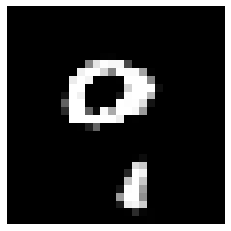

Time for epoch 24 is 6.319032669067383 sec


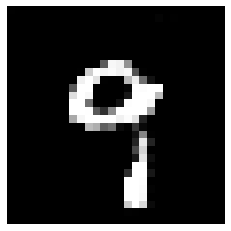

Time for epoch 25 is 6.4073569774627686 sec


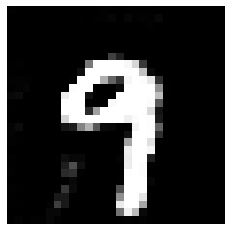

Time for epoch 26 is 6.522913694381714 sec


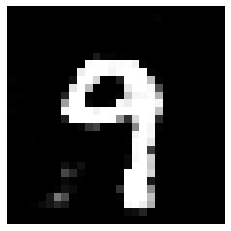

Time for epoch 27 is 6.209884166717529 sec


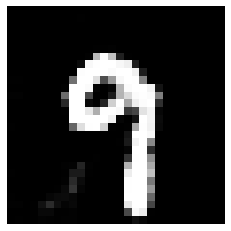

Time for epoch 28 is 6.33179497718811 sec


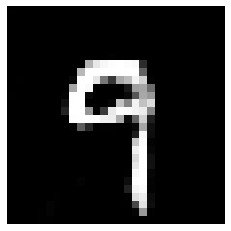

Time for epoch 29 is 6.216064453125 sec


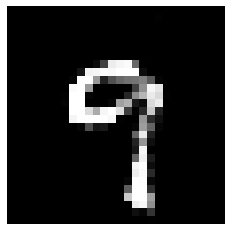

Time for epoch 30 is 6.511083126068115 sec


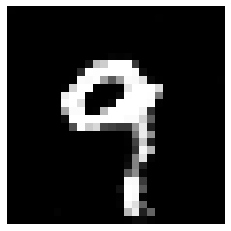

Time for epoch 31 is 6.183514356613159 sec


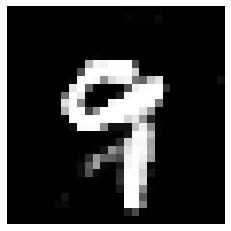

Time for epoch 32 is 6.264758348464966 sec


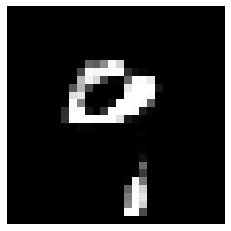

Time for epoch 33 is 6.299211502075195 sec


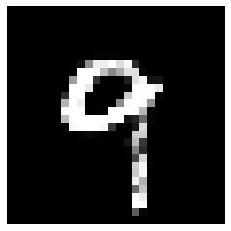

Time for epoch 34 is 6.174717426300049 sec


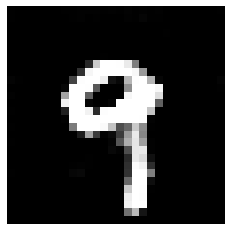

Time for epoch 35 is 6.178935766220093 sec


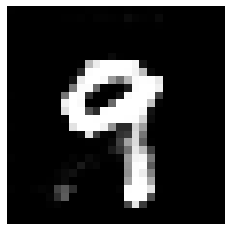

Time for epoch 36 is 6.361151218414307 sec


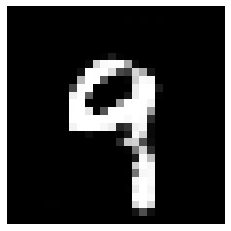

Time for epoch 37 is 6.336986780166626 sec


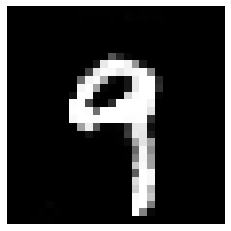

Time for epoch 38 is 6.214864492416382 sec


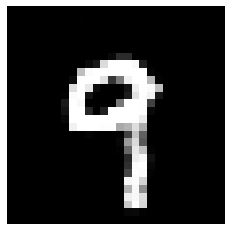

Time for epoch 39 is 6.104611396789551 sec


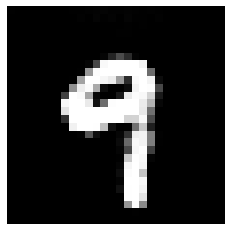

Time for epoch 40 is 6.193329334259033 sec


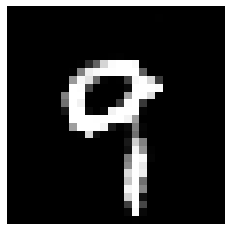

Time for epoch 41 is 6.40531849861145 sec


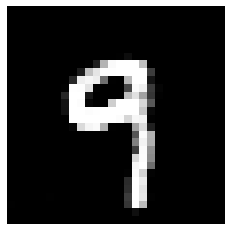

Time for epoch 42 is 6.361441373825073 sec


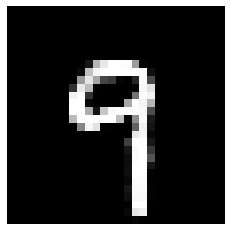

Time for epoch 43 is 6.3653364181518555 sec


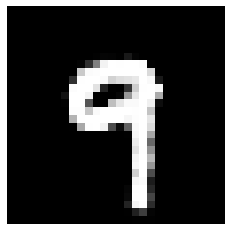

Time for epoch 44 is 6.1659533977508545 sec


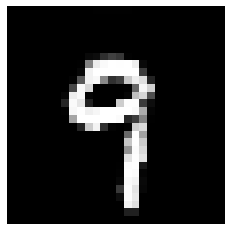

Time for epoch 45 is 6.386273145675659 sec


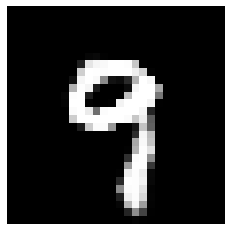

Time for epoch 46 is 6.14234471321106 sec


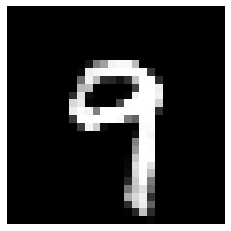

Time for epoch 47 is 6.098533391952515 sec


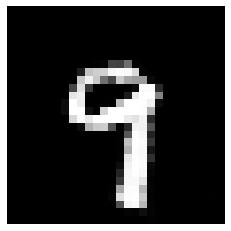

Time for epoch 48 is 6.156270265579224 sec


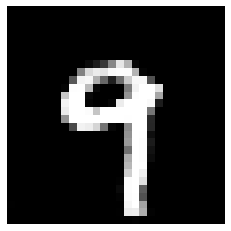

Time for epoch 49 is 6.229960680007935 sec


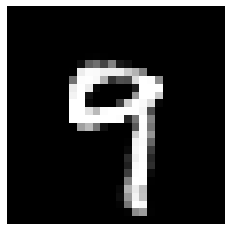

Time for epoch 50 is 6.23050856590271 sec


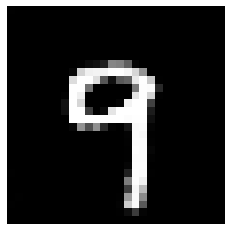

Time for epoch 51 is 6.269151449203491 sec


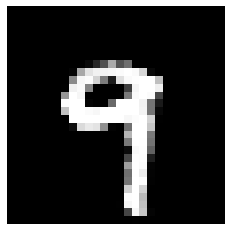

Time for epoch 52 is 6.188017129898071 sec


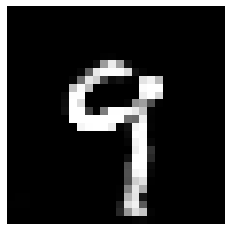

Time for epoch 53 is 6.036686420440674 sec


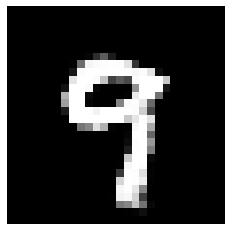

Time for epoch 54 is 6.171655893325806 sec


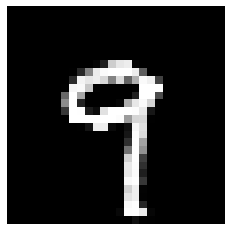

Time for epoch 55 is 6.201847076416016 sec


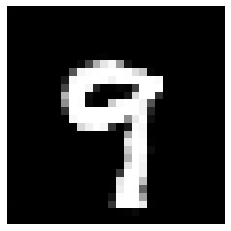

Time for epoch 56 is 6.426925182342529 sec


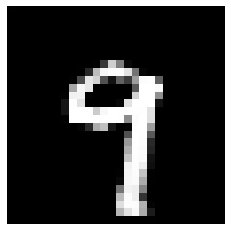

Time for epoch 57 is 6.059063196182251 sec


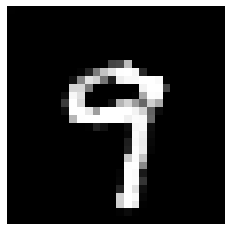

Time for epoch 58 is 6.231424570083618 sec


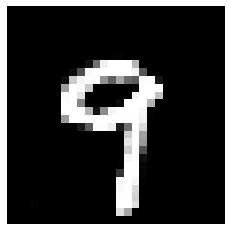

Time for epoch 59 is 6.206666946411133 sec


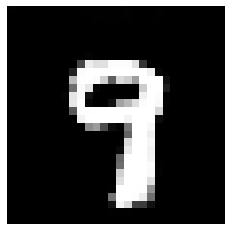

Time for epoch 60 is 6.0963475704193115 sec


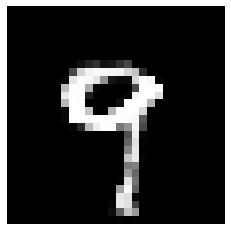

Time for epoch 61 is 6.207415819168091 sec


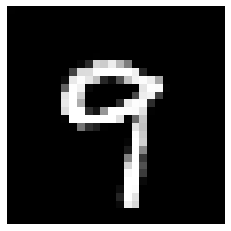

Time for epoch 62 is 6.261555433273315 sec


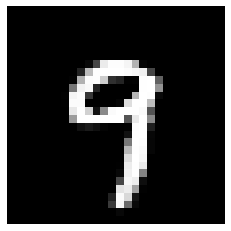

Time for epoch 63 is 6.129943370819092 sec


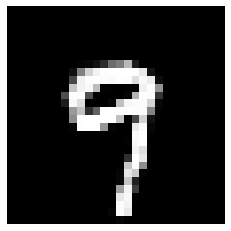

Time for epoch 64 is 5.976783752441406 sec


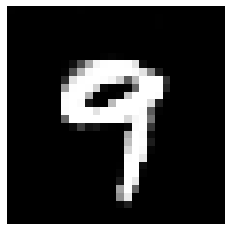

Time for epoch 65 is 6.132240533828735 sec


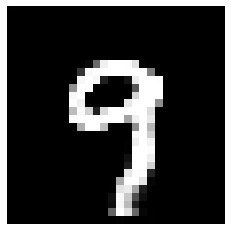

Time for epoch 66 is 6.0679285526275635 sec


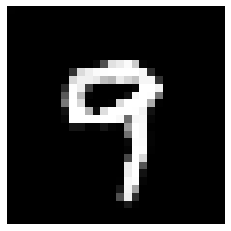

Time for epoch 67 is 6.043112516403198 sec


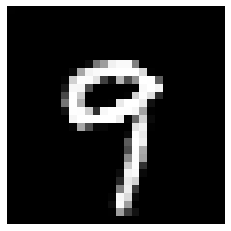

Time for epoch 68 is 6.216166734695435 sec


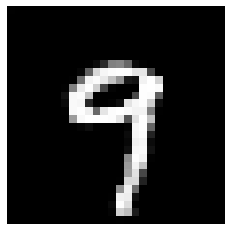

Time for epoch 69 is 6.189884424209595 sec


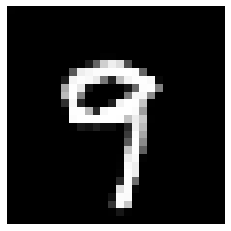

Time for epoch 70 is 6.117764711380005 sec


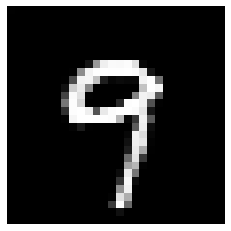

Time for epoch 71 is 6.078130722045898 sec


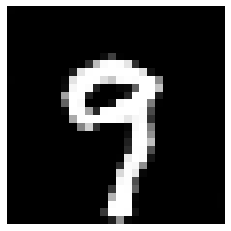

Time for epoch 72 is 6.115118741989136 sec


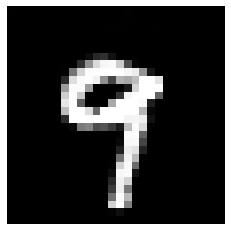

Time for epoch 73 is 6.0081400871276855 sec


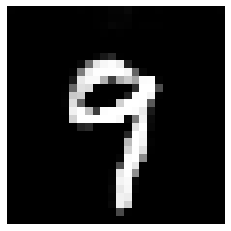

Time for epoch 74 is 6.087448596954346 sec


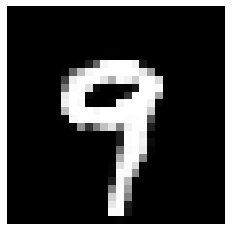

Time for epoch 75 is 6.030056953430176 sec


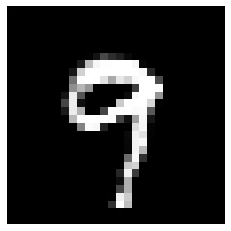

Time for epoch 76 is 6.168945789337158 sec


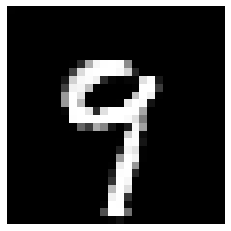

Time for epoch 77 is 6.176825284957886 sec


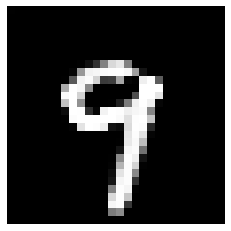

Time for epoch 78 is 6.728787422180176 sec


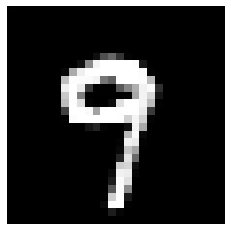

Time for epoch 79 is 6.658181428909302 sec


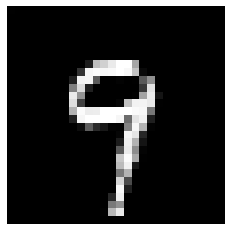

Time for epoch 80 is 6.38550066947937 sec


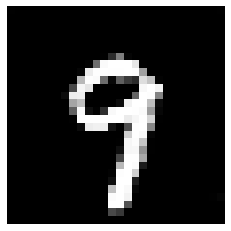

Time for epoch 81 is 6.445242404937744 sec


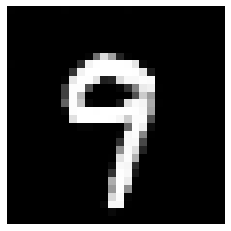

Time for epoch 82 is 6.519482135772705 sec


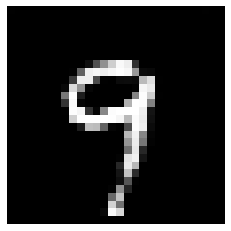

Time for epoch 83 is 6.276028871536255 sec


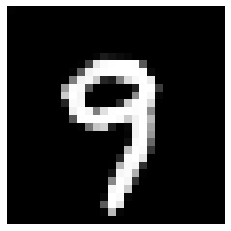

Time for epoch 84 is 6.392621278762817 sec


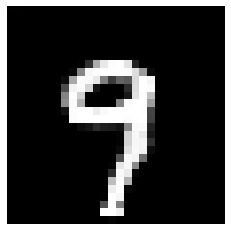

Time for epoch 85 is 6.221600532531738 sec


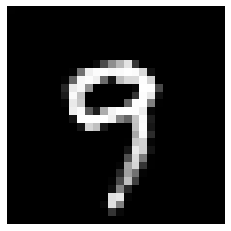

Time for epoch 86 is 6.445392847061157 sec


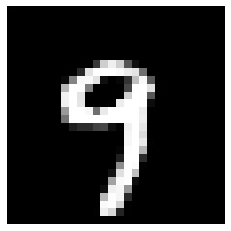

Time for epoch 87 is 6.334048271179199 sec


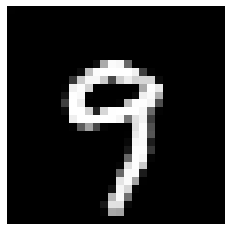

Time for epoch 88 is 6.391742706298828 sec


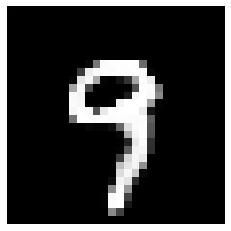

Time for epoch 89 is 6.286293268203735 sec


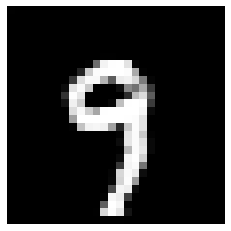

Time for epoch 90 is 6.327468395233154 sec


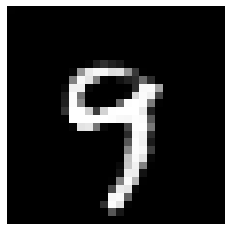

Time for epoch 91 is 6.520931720733643 sec


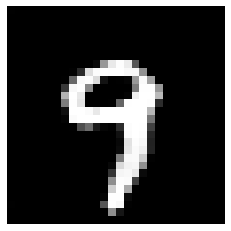

Time for epoch 92 is 6.242173194885254 sec


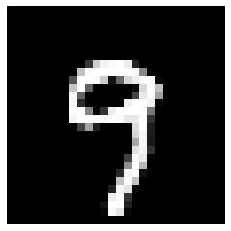

Time for epoch 93 is 6.274125337600708 sec


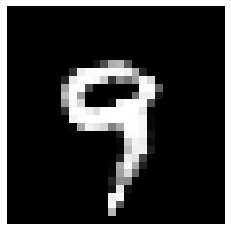

Time for epoch 94 is 6.327028274536133 sec


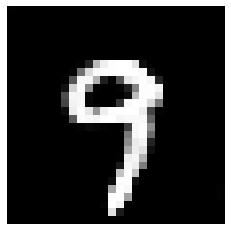

Time for epoch 95 is 6.273791313171387 sec


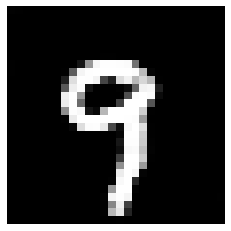

Time for epoch 96 is 6.2806854248046875 sec


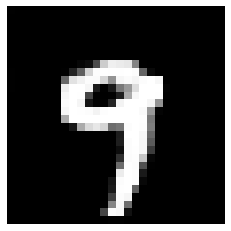

Time for epoch 97 is 6.300726413726807 sec


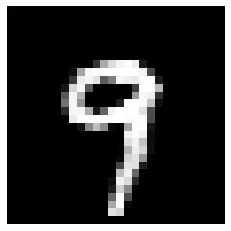

Time for epoch 98 is 7.145082235336304 sec


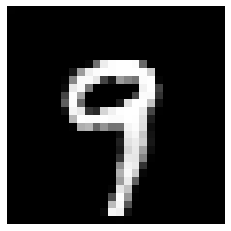

Time for epoch 99 is 6.360941171646118 sec


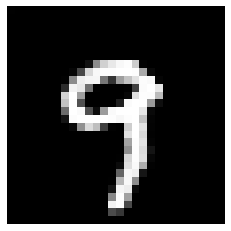

Time for epoch 100 is 6.258055210113525 sec


In [ ]:
train(train_dataset, EPOCHS)

### Run following code only if there is a disconnection and you wish to continue training from the last checkpoint

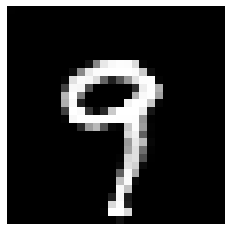

Time for epoch 1 is 6.2479681968688965 sec


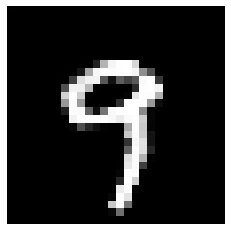

Time for epoch 2 is 6.162464618682861 sec


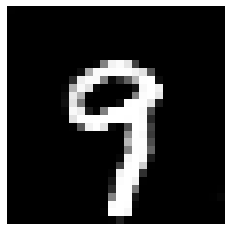

Time for epoch 3 is 6.3007612228393555 sec


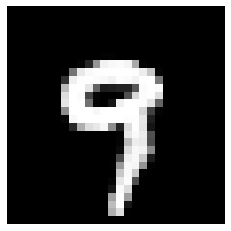

Time for epoch 4 is 6.263478517532349 sec


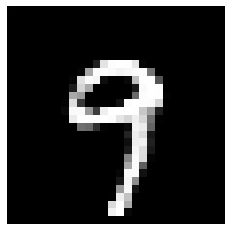

Time for epoch 5 is 6.2966344356536865 sec


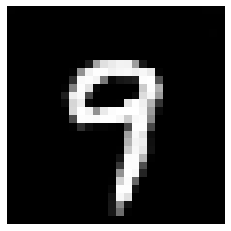

Time for epoch 6 is 6.282685279846191 sec


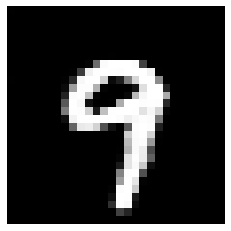

Time for epoch 7 is 6.39206337928772 sec


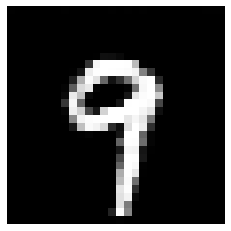

Time for epoch 8 is 6.385505676269531 sec


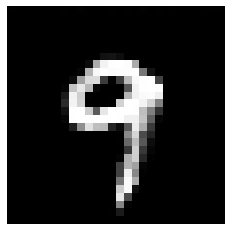

Time for epoch 9 is 6.331223249435425 sec


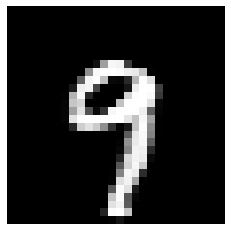

Time for epoch 10 is 6.265676259994507 sec


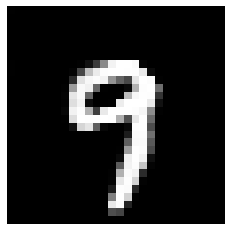

Time for epoch 11 is 6.550157785415649 sec


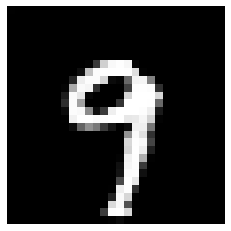

Time for epoch 12 is 6.585537672042847 sec


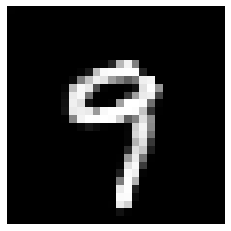

Time for epoch 13 is 6.16161847114563 sec


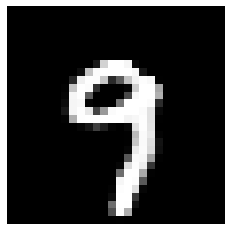

Time for epoch 14 is 6.252596378326416 sec


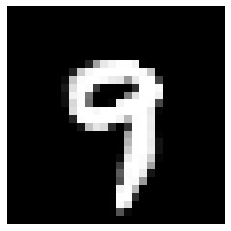

Time for epoch 15 is 6.235682487487793 sec


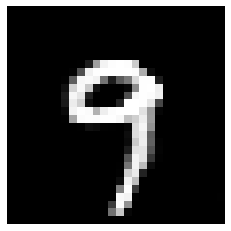

Time for epoch 16 is 6.3738017082214355 sec


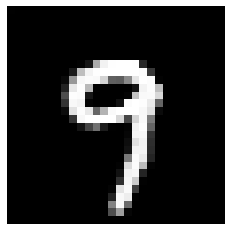

Time for epoch 17 is 6.385351657867432 sec


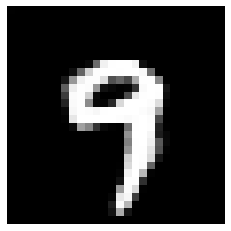

Time for epoch 18 is 7.086938858032227 sec


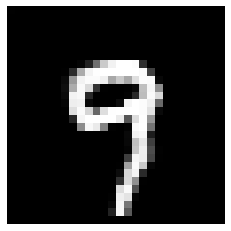

Time for epoch 19 is 6.397108793258667 sec


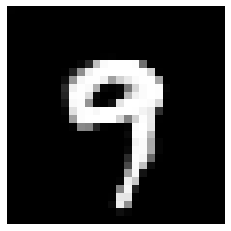

Time for epoch 20 is 6.285693645477295 sec


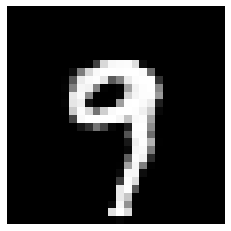

Time for epoch 21 is 6.277593374252319 sec


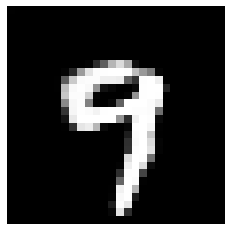

Time for epoch 22 is 6.203434944152832 sec


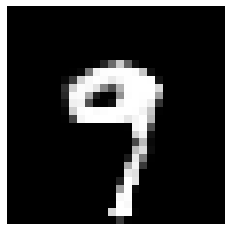

Time for epoch 23 is 6.235035181045532 sec


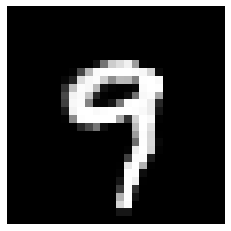

Time for epoch 24 is 6.151073932647705 sec


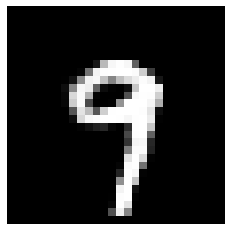

Time for epoch 25 is 6.244985580444336 sec


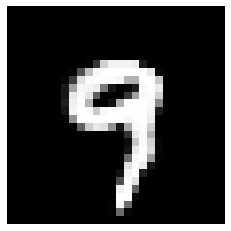

Time for epoch 26 is 6.446706771850586 sec


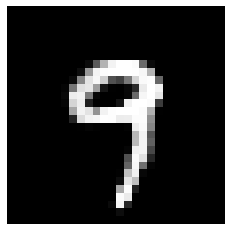

Time for epoch 27 is 6.279846668243408 sec


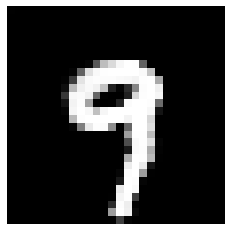

Time for epoch 28 is 6.166829586029053 sec


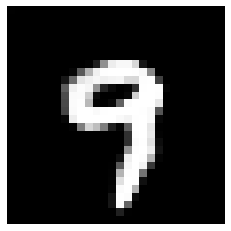

Time for epoch 29 is 6.566675186157227 sec


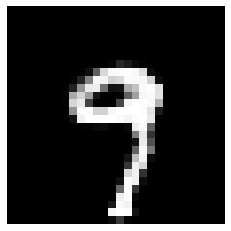

Time for epoch 30 is 6.133523941040039 sec


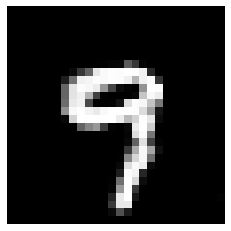

Time for epoch 31 is 6.411322355270386 sec


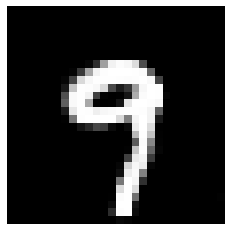

Time for epoch 32 is 6.344169616699219 sec


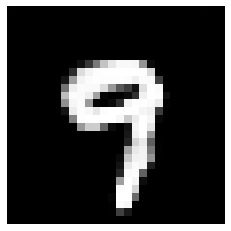

Time for epoch 33 is 6.199097394943237 sec


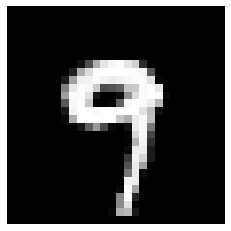

Time for epoch 34 is 6.2583327293396 sec


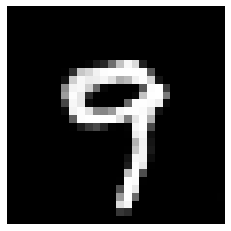

Time for epoch 35 is 6.254526138305664 sec


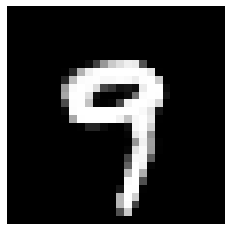

Time for epoch 36 is 6.31012225151062 sec


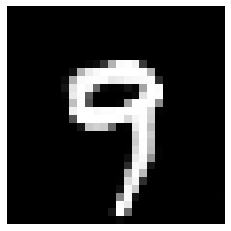

Time for epoch 37 is 6.2045676708221436 sec


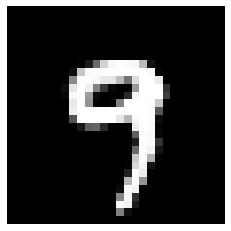

Time for epoch 38 is 6.3069775104522705 sec


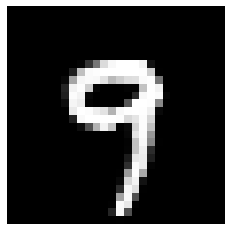

Time for epoch 39 is 7.015054702758789 sec


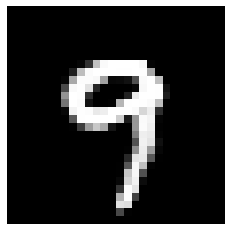

Time for epoch 40 is 6.307055711746216 sec


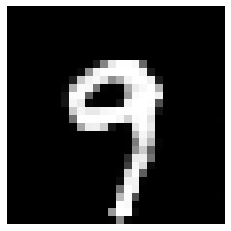

Time for epoch 41 is 6.218873977661133 sec


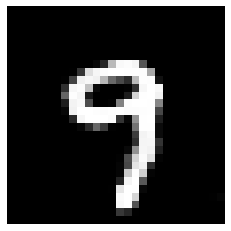

Time for epoch 42 is 6.316851615905762 sec


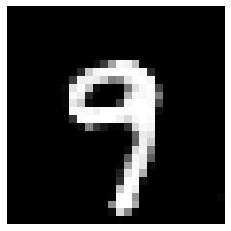

Time for epoch 43 is 6.329731702804565 sec


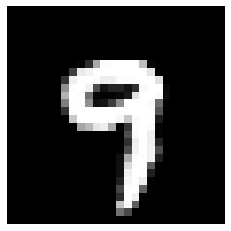

Time for epoch 44 is 6.226006746292114 sec


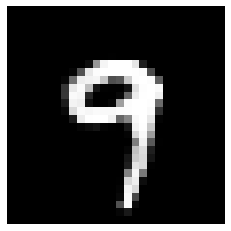

Time for epoch 45 is 6.45923376083374 sec


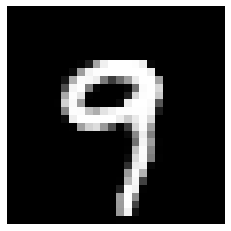

Time for epoch 46 is 6.30166482925415 sec


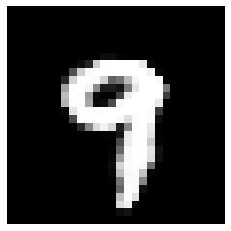

Time for epoch 47 is 6.30011248588562 sec


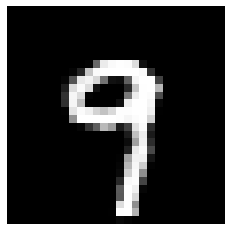

Time for epoch 48 is 6.183405160903931 sec


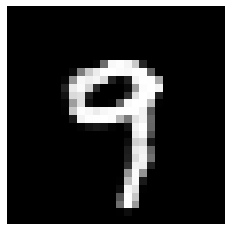

Time for epoch 49 is 6.197137355804443 sec


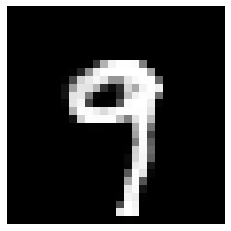

Time for epoch 50 is 6.1831159591674805 sec


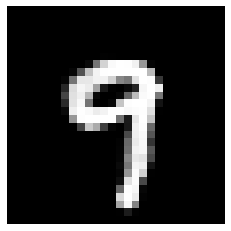

Time for epoch 51 is 6.307071208953857 sec


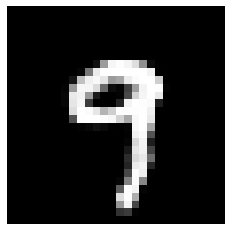

Time for epoch 52 is 6.389654636383057 sec


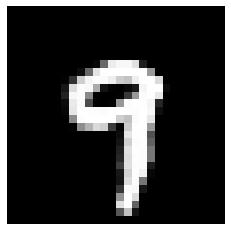

Time for epoch 53 is 6.172191858291626 sec


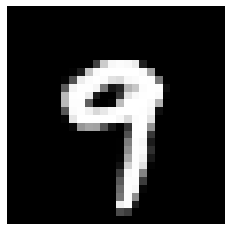

Time for epoch 54 is 6.287686824798584 sec


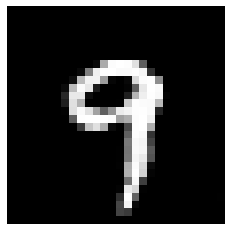

Time for epoch 55 is 6.267473936080933 sec


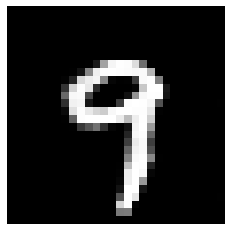

Time for epoch 56 is 6.4129674434661865 sec


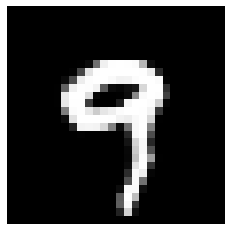

Time for epoch 57 is 6.355336904525757 sec


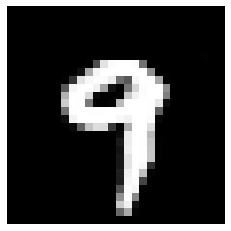

Time for epoch 58 is 6.277109384536743 sec


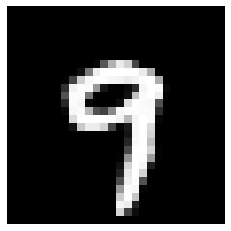

Time for epoch 59 is 6.318014621734619 sec


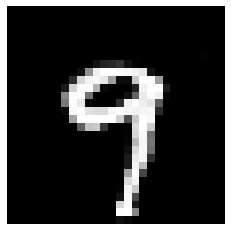

Time for epoch 60 is 6.604807138442993 sec


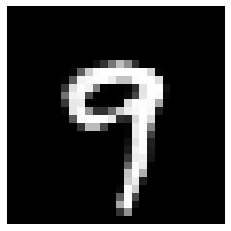

Time for epoch 61 is 6.574779272079468 sec


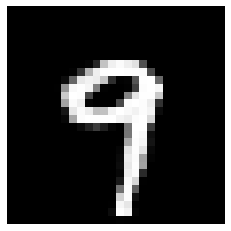

Time for epoch 62 is 6.8662025928497314 sec


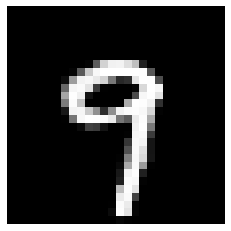

Time for epoch 63 is 6.648370742797852 sec


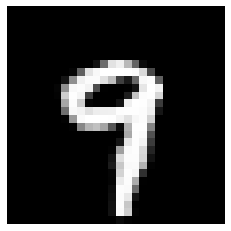

Time for epoch 64 is 6.469580888748169 sec


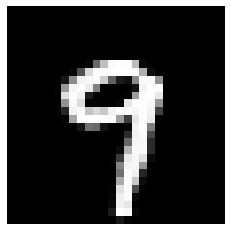

Time for epoch 65 is 6.266538143157959 sec


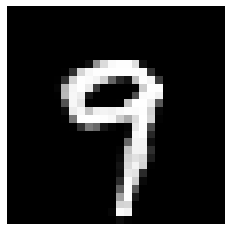

Time for epoch 66 is 6.470162630081177 sec


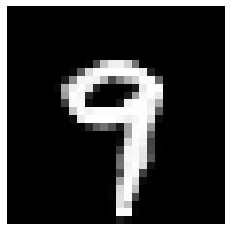

Time for epoch 67 is 6.220447301864624 sec


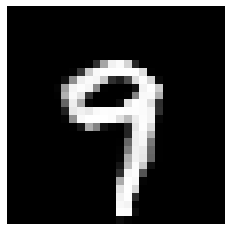

Time for epoch 68 is 6.569842576980591 sec


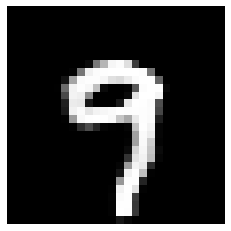

Time for epoch 69 is 6.202866077423096 sec


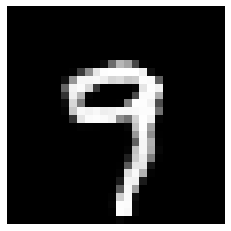

Time for epoch 70 is 6.330986261367798 sec


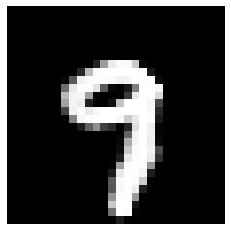

Time for epoch 71 is 6.316926717758179 sec


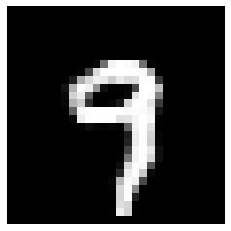

Time for epoch 72 is 6.384703874588013 sec


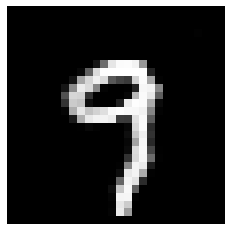

Time for epoch 73 is 6.244466781616211 sec


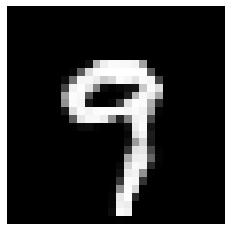

Time for epoch 74 is 6.306459426879883 sec


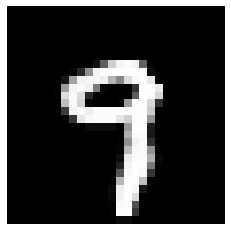

Time for epoch 75 is 6.273855924606323 sec


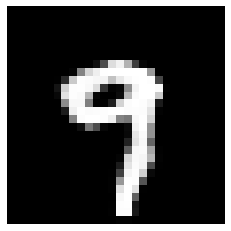

Time for epoch 76 is 6.241577863693237 sec


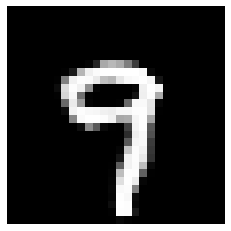

Time for epoch 77 is 6.20664644241333 sec


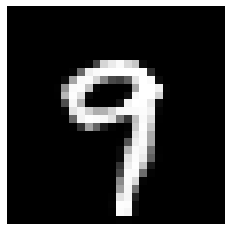

Time for epoch 78 is 6.244994401931763 sec


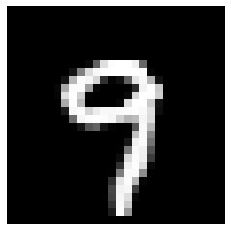

Time for epoch 79 is 6.221446514129639 sec


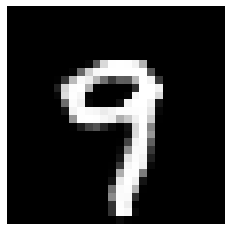

Time for epoch 80 is 6.217912912368774 sec


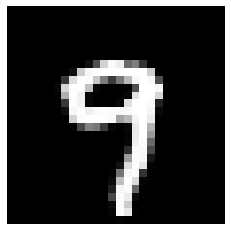

Time for epoch 81 is 6.297033309936523 sec


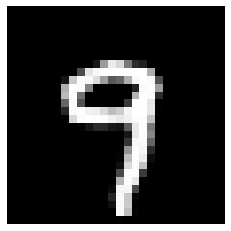

Time for epoch 82 is 6.253932237625122 sec


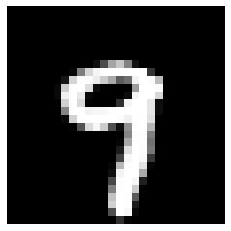

Time for epoch 83 is 6.3897013664245605 sec


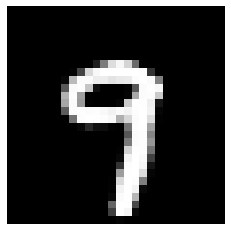

Time for epoch 84 is 6.268230199813843 sec


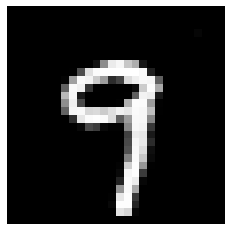

Time for epoch 85 is 6.3235085010528564 sec


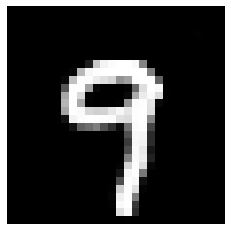

Time for epoch 86 is 6.21071720123291 sec


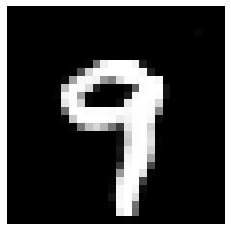

Time for epoch 87 is 6.240511178970337 sec


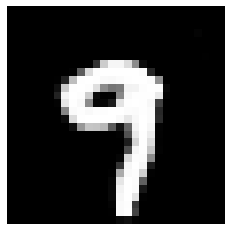

Time for epoch 88 is 6.23640513420105 sec


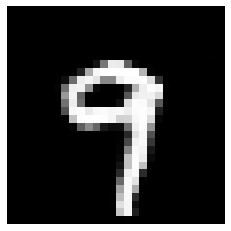

Time for epoch 89 is 6.2778160572052 sec


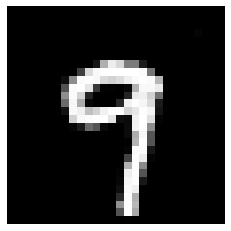

Time for epoch 90 is 6.262451171875 sec


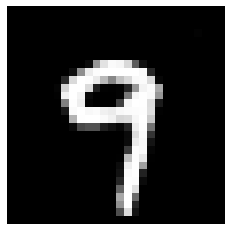

Time for epoch 91 is 6.3328306674957275 sec


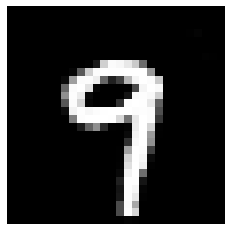

Time for epoch 92 is 6.262130975723267 sec


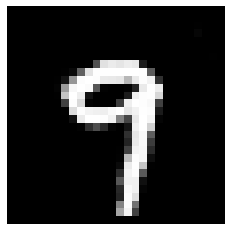

Time for epoch 93 is 6.44684362411499 sec


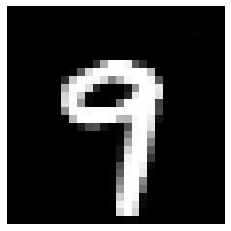

Time for epoch 94 is 6.6497273445129395 sec


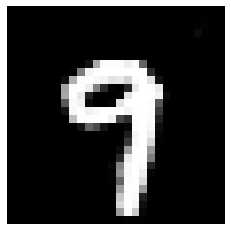

Time for epoch 95 is 6.822926759719849 sec


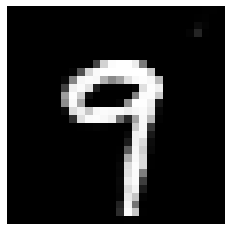

Time for epoch 96 is 6.351921558380127 sec


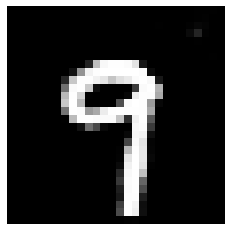

Time for epoch 97 is 6.223947763442993 sec


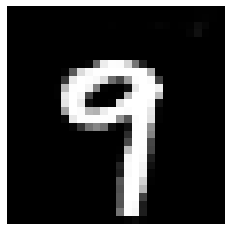

Time for epoch 98 is 6.315193176269531 sec


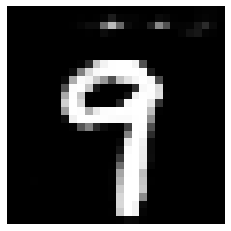

Time for epoch 99 is 6.414262056350708 sec


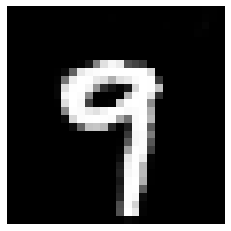

Time for epoch 100 is 6.3392109870910645 sec


In [ ]:
#run this code only if there is a runtime disconnection
try:
     checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
except Exception as error:
    print("Error loading in model : {}".format(error))
train(train_dataset, EPOCHS)